In [118]:
# Setup scenario
from constants import DATA_ENTITIES_DIR, DATA_HAZARDS_DIR, DATA_TEMP_DIR, REQUIREMENTS_DIR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

from costben.costben_handler import CostBenefitHandler
from exposure.exposure_handler import ExposureHandler
from hazard.hazard_handler import HazardHandler
from impact.impact_handler import ImpactHandler

import handlers
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])

costben_handler = CostBenefitHandler()
exposure_handler = ExposureHandler()
hazard_handler = HazardHandler()
impact_handler = ImpactHandler()


# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"  # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"  # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = (
    "rcp26"  # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
)
time_horizon = "2030_2050"  # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']
annual_growth = 1.01

client = Client()

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "exposures"
]
hazard_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "hazard"
]

print(
    f"Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}")

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        "country_name": country_name,
    }
)

exposure_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "exposures"
        ]
    )
)
hazard_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "hazard"
        ]
    )
)

print(
    f"Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}")

In [ ]:
# Available climate scenarios and time horizons for specific hazard type in countries Thailand and Egypt
if hazard_type == "river_flood" or "wildfire":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "tropical_cyclone":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties.get("ref_year")
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "earthquake":
    available_scenarios = []
    available_time_horizons = []
if hazard_type == "flood":
    available_scenarios = []
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )

print(
    f"Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}"
)
print(
    f"Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}"
)

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": hazard_type,
        "country_name": country_name,
        # "climate_scenario": climate_scenario,
    }
)
hazard_dataset_infos

In [7]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = exposure_handler.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, 2040)

In [34]:
future_year = 2080

exposure_present = client.get_litpop("Egypt")
exposure_present.gdf.rename(columns={"impf_": "impf_RF"}, inplace=True)
exposure_present.gdf['impf_RF'] = 1

if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, future_year)
    exposure_future.gdf.rename(columns={"impf_": "impf_RF"}, inplace=True)
    exposure_future.gdf['impf_RF'] = 1
    
hazard_present = client.get_hazard('river_flood', 
                                properties={'country_name': 'Egypt', 
                                            'climate_scenario': 'historical',
                                            'nb_synth_tracks':'10'})
hazard_future = client.get_hazard('river_flood', 
                                properties={'country_name': 'Egypt', 
                                            'climate_scenario': 'rcp60',
                                            'ref_year': str(future_year),
                                            'nb_synth_tracks':'10'})    

exposure_present.assign_centroids(hazard_present, distance='approx')
if annual_growth > 1:
    exposure_future.assign_centroids(hazard_future, distance='approx')

impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()


measure_set = costben_handler.get_measure_set_from_excel('TC')
discount_rates = costben_handler.get_discount_rates_from_excel()

# Create Entity objects
entity_present = exposure_handler.get_entity(
    exposure_present, discount_rates, impf_set, measure_set
)

if scenario != "historical":
    entity_future = exposure_handler.get_entity(
        exposure_future, discount_rates, impf_set, measure_set
    )

cost_benefit = costben_handler.calculate_cost_benefit(hazard_present, entity_present, hazard_future, entity_future, future_year=2040)
cost_benefit

2024-02-23 11:40:38,478 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 16855 coordinates.
2024-02-23 11:40:44,030 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 16855 coordinates.


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from climada.entity.measures import Measure, MeasureSet

meas_1 = Measure(
    haz_type='TC',
    name='Measure A',
    color_rgb=np.array([0.8, 0.1, 0.1]),
    cost=5000000000,
    hazard_inten_imp=(1, -5),     # Decrease wind speeds by 5 m/s
    risk_transf_cover=0,
)

meas_2 = Measure(
    haz_type='TC',
    name='Measure B',
    color_rgb=np.array([0.1, 0.1, 0.8]),
    cost=220000000,
    paa_impact=(1, -0.10),   # 10% fewer assets affected
)

meas_1.exp_region_id

# gather all measures
# measure_set = MeasureSet(measure_list=[meas_1, meas_2])
# measure_set.check()
# print(measure_set.get_measure())

# # Create Entity objects
# entity_present = exposure_handler.get_entity(
#     exposure_present, discount_rates, impf_set, measure_set
# )

# if scenario != "historical":
#     entity_future = exposure_handler.get_entity(
#         exposure_future, discount_rates, impf_set, measure_set
#     )

# cost_benefit = costben_handler.calculate_cost_benefit(hazard_present, entity_present, hazard_future, entity_future, future_year=2040)
# cost_benefit


[]

In [123]:
measure_set = MeasureSet.from_excel(REQUIREMENTS_DIR / "adaptation_measures.xlsx")
# measure_set.get_measure()
# measure_set.remove_measure('TS')
# measure_set.remove_measure('RF')

# print(measure_set.get_names())

# measure_set = costben_handler.get_measure_set_from_excel('TC')

meas_1 = measure_set.get_measure('TC', 'beach nourishment')
meas_2 = measure_set.get_measure('TC', 'vegetation management')
# meas_3 = measure_set.get_measure('TC', 'enforce building code')
meas_4 = measure_set.get_measure('TC', 'risk transfer')

measure_set = MeasureSet(measure_list=[meas_1, meas_2, meas_4])

entity_present = exposure_handler.get_entity(
    exposure_present, discount_rates, impf_set, measure_set
)

if scenario != "historical":
    entity_future = exposure_handler.get_entity(
        exposure_future, discount_rates, impf_set, measure_set
    )

cost_benefit = costben_handler.calculate_cost_benefit(hazard_present, entity_present, hazard_future, entity_future, future_year=2040)
cost_benefit

2024-02-23 13:22:47,643 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 17378 coordinates.
2024-02-23 13:22:47,711 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 17378 coordinates.

Measure                  Cost (USD )    Benefit (USD )    Benefit/Cost
---------------------  -------------  ----------------  --------------
beach nourishment        4.05725e+07                 0               0
vegetation management    6.39681e+07                 0               0
risk transfer            2.1e+07                     0               0

--------------------  -  ------
Total climate risk:   0  (USD )
Average annual risk:  0  (USD )
Residual risk:        0  (USD )
--------------------  -  ------
Net Present Values


In [18]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard_present = hazard_handler.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = hazard_handler.get_hazard(
        hazard_type,
        scenario,
        time_horizon,
        country_name,
    )

In [19]:
# Get Impact
impact_function_set = impact_handler.calculate_impact_function_set(hazard_present)
impact_present = impact_handler.calculate_impact(exposure_present, hazard_present, impact_function_set)

if scenario != "historical":
    if annual_growth > 1:
        impact_future = impact_handler.calculate_impact(
            exposure_future, hazard_future, impact_function_set)
    impact_future = impact_handler.calculate_impact(
        exposure_present, hazard_future, impact_function_set)

In [20]:
measure_set = costben_handler.get_measure_set_from_excel('RF')
discount_rates = costben_handler.get_discount_rates_from_excel()

In [21]:
# Create Entity objects
entity_present = exposure_handler.get_entity(
    exposure_present, discount_rates, impact_function_set, measure_set
)

if scenario != "historical":
    entity_future = exposure_handler.get_entity(
        exposure_future, discount_rates, impact_function_set, measure_set
    )

In [22]:
cost_benefit = costben_handler.calculate_cost_benefit(hazard_present, entity_present, hazard_future, entity_future, future_year=2040)
cost_benefit


Measure        Cost (USD )    Benefit (USD )    Benefit/Cost
-----------  -------------  ----------------  --------------
river banks          1e+06                 0               0
sandbags        500000                     0               0
river wall      200000                     0               0

--------------------  -----------  ------
Total climate risk:   1.14099e+11  (USD )
Average annual risk:  1.20042e+10  (USD )
Residual risk:        1.14099e+11  (USD )
--------------------  -----------  ------
Net Present Values


In [23]:
costben_disc = CostBenefit()
costben_disc.calc(hazard_present, entity_present, haz_future=hazard_future, ent_future=entity_future,
                  future_year=2024, risk_func=risk_aai_agg, imp_time_depen=1, save_imp=True)


Measure        Cost (USD )    Benefit (USD )    Benefit/Cost
-----------  -------------  ----------------  --------------
river banks          1e+06                 0               0
sandbags        500000                     0               0
river wall      200000                     0               0

--------------------  -----------  ------
Total climate risk:   1.14099e+11  (USD )
Average annual risk:  1.20042e+10  (USD )
Residual risk:        1.14099e+11  (USD )
--------------------  -----------  ------
Net Present Values


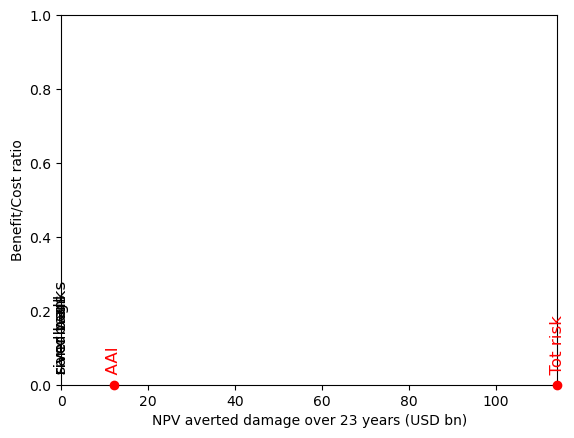

In [24]:
ax = costben_disc.plot_cost_benefit()

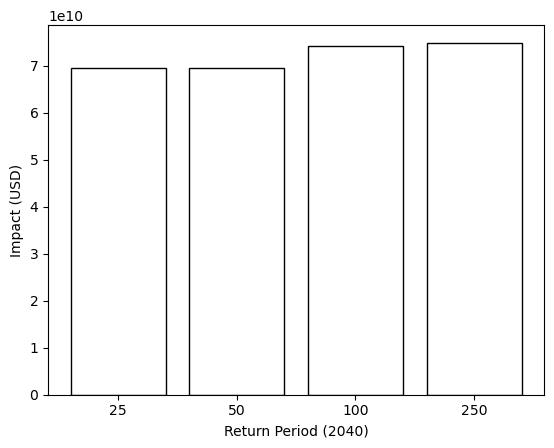

In [25]:
# ax = cost_benefit.plot_cost_benefit()
ax = costben_disc.plot_event_view((25, 50, 100, 250))

In [16]:
entity_present = exposure_handler.get_entity_from_xlsx("entity_template.xlsx")
exposure_present = entity_present.exposures
hazard_present = hazard_handler.get_hazard_from_xlsx("hazard_template.xlsx")

exposure_present.assign_centroids(hazard_present, distance='approx')
hazard_present.haz_type = 'D'

AttributeError: 'NoneType' object has no attribute 'exposures'